# **PREDICT SALES PRICE NOTEBOOK**

<br>

## Objectives

* Fit and evaluate a regression model to predict summed sales price of the 4 inherited houses.
  
## Inputs

* outputs/datasets/collection/house_prices_after_inspection.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to sales price
* labels map
* Feature Importance Plot

---

# Change working directory to the parent folder

Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-heritage-housing-issues/jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-heritage-housing-issues'

# Load the Data

In [59]:
import pandas as pd
df = (pd.read_csv(
  "outputs/datasets/collection/house_prices_after_inspection.csv").
  drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1)
  )

df.tail()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
1455,953,694.0,3.0,No,0,Unf,953,460,RFn,1999.0,...,7917,62.0,0.0,40,5,6,953,1999,2000,175000
1456,2073,0.0,NaN,No,790,ALQ,589,500,Unf,1978.0,...,13175,85.0,119.0,0,6,6,1542,1978,1988,210000
1457,1188,1152.0,4.0,No,275,GLQ,877,252,RFn,1941.0,...,9042,66.0,0.0,60,9,7,1152,1941,2006,266500
1458,1078,0.0,2.0,Mn,49,NaN,0,240,Unf,1950.0,...,9717,68.0,0.0,0,6,5,1078,1950,1996,142125
1459,1256,0.0,3.0,No,830,BLQ,136,276,Fin,1965.0,...,9937,75.0,0.0,68,6,5,1256,1965,1965,147500


# ML Pipeline: Regressor

### Step 1: Create ML pipeline

In [60]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer


# Feature Engineering
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("categorical_imputation", CategoricalImputer(imputation_method='missing',
                                                  fill_value='Missing',
                                                  variables=['BsmtExposure', 
                                                             'BsmtFinType1', 
                                                             'GarageFinish', 
                                                            'KitchenQual'])),
        
        ("numerical_imputation", MeanMedianImputer(imputation_method='median',
                            variables= ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr',
                                         'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea'
                                         , 'GarageYrBlt', 'GrLivArea', 'LotArea'
                                         , 'LotFrontage', 'MasVnrArea', 
                                         'OpenPorchSF', 'OverallCond', 
                                         'OverallQual', 'TotalBsmtSF', 
                                         'YearBuilt', 'YearRemodAdd'])),

        ("winsorizer_iqr", Winsorizer(capping_method='iqr',
                            tail='both', fold=1.5, 
                            variables= ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1',
        'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea',
        'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', 'YearBuilt',
        'YearRemodAdd'])),

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
        variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 
        'KitchenQual'])),
        
        ("yjt", vt.YeoJohnsonTransformer(variables = ['1stFlrSF', '2ndFlrSF',
        'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt',
        'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF',
        'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 
        'BsmtExposure', 'BsmtFinType1', 'GarageFinish', 
        'KitchenQual'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

# Split Train Test Set

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


In [29]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

# Grid Search CV - Sklearn

* Use default hyperparameters to find most suitable algorithm

In [62]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

* Load Custom Class for hyperparameter optimisation (provided by Code Institute)

In [63]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

* Perform a hyperparameter optimisation search using the default hyperparameters

In [64]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype i


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype

* Check the results

In [65]:
import numpy as np
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.706966,0.776609,0.8501,0.052155
3,ExtraTreesRegressor,0.694295,0.757923,0.836489,0.045686
0,LinearRegression,0.663136,0.749982,0.815848,0.049088
2,RandomForestRegressor,0.592592,0.741995,0.854636,0.094531
4,AdaBoostRegressor,0.624768,0.70347,0.764864,0.046345
6,XGBRegressor,0.576846,0.688406,0.781135,0.073341
1,DecisionTreeRegressor,0.45409,0.564277,0.679122,0.09544


# Perform an extensive search on the most suitable model to find the best hyperparameter configuration

#### Define model and parameters, for Extensive Search

In [66]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    #"ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

#### Extensive GridSearch CV


In [67]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype

#### Check the results

In [68]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingRegressor,0.706966,0.776609,0.8501,0.052155,0.1,3,100
7,GradientBoostingRegressor,0.721402,0.77654,0.849196,0.049697,0.01,3,300
1,GradientBoostingRegressor,0.674369,0.760831,0.83195,0.054375,0.1,3,300
9,GradientBoostingRegressor,0.583948,0.728756,0.801348,0.076374,0.01,10,300
2,GradientBoostingRegressor,0.568828,0.724439,0.806234,0.08382,0.1,10,100
3,GradientBoostingRegressor,0.567779,0.722883,0.805822,0.084017,0.1,10,300
11,GradientBoostingRegressor,0.531803,0.674729,0.747537,0.079126,0.01,None,300
8,GradientBoostingRegressor,0.644615,0.669084,0.694876,0.020149,0.01,10,100
4,GradientBoostingRegressor,0.487179,0.658295,0.740088,0.092947,0.1,None,100
5,GradientBoostingRegressor,0.487156,0.658287,0.740087,0.092955,0.1,None,300


#### Get the best model

In [69]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

#### Get the parameters for best model

In [70]:
best_parameters = grid_search_pipelines[best_model].best_params_

#### Define the best regressor, based on search

In [71]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('categorical_imputation',
                 CategoricalImputer(variables=['BsmtExposure', 'BsmtFinType1',
                                               'GarageFinish',
                                               'KitchenQual'])),
                ('numerical_imputation',
                 MeanMedianImputer(variables=['1stFlrSF', '2ndFlrSF',
                                              'BedroomAbvGr', 'BsmtFinSF1',
                                              'BsmtUnfSF', 'GarageArea',
                                              'GarageYrBlt', 'GrLivArea',
                                              'LotArea', 'LotFrontage',
                                              'MasVnrArea', 'OpenPorchSF',
                                              'OverallCon...
                                                  'BsmtExposure',
                                                  'BsmtFinType1',
                                                  'GarageFinish',
                                                  'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model', GradientBoostingRegressor(random_state=0))])

# Evaluate on Train and Test Sets

* Use custom functions defined by Code Institute

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

#### Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.902
Mean Absolute Error: 17900.24
Mean Squared Error: 604472224.893
Root Mean Squared Error: 24586.017


* Test Set
R2 Score: 0.758
Mean Absolute Error: 23756.986
Mean Squared Error: 1672266215.669
Root Mean Squared Error: 40893.352




/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype i

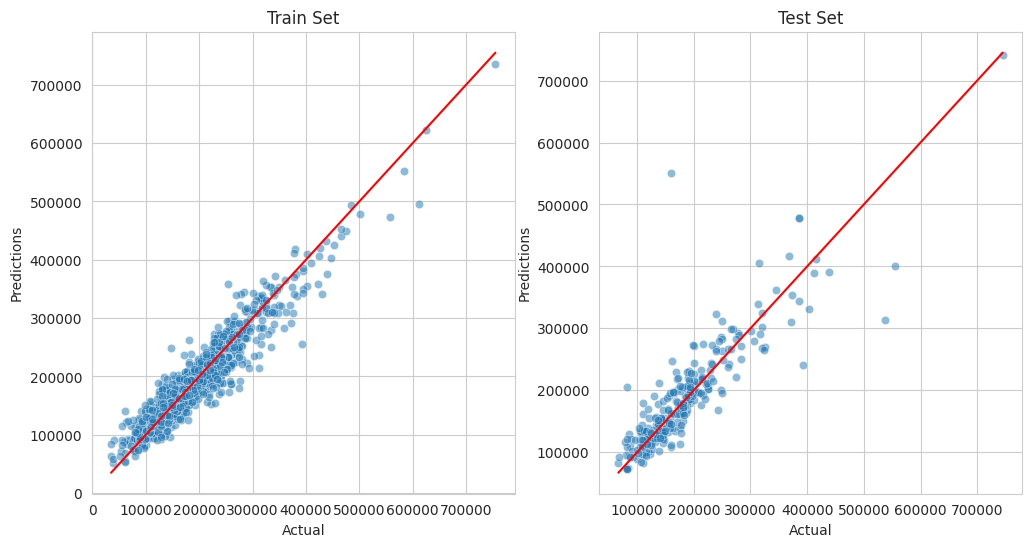

In [73]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Assess feature importance

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype i

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


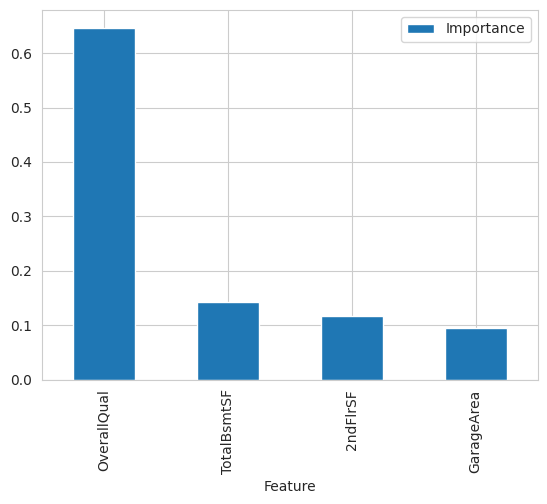

In [74]:
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 6
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Observations (CHANGE THE BELOW)

* The variables EnclosedPorch and WoodDeckSF have more than 80 % of missing
  data. Thus, these two variables will likely be dropped. 
* 10 variables have missing values: 2ndFlrSF, BedroomAbvGr, BsmtExposure,
  BsmtFinType1, EnclosedPorch, GarageFinish, GarageYrBlt, LotFrontage, 
  MasVnrArea, and WoodDeckSF.
* The categorical variables are imbalanced.
* The categorical variables BsmtFinType1 and KitchenQual show inconsistent
  casing. Thus, for consistency apply a case transformation to all categorical
  variables.
* Most numerical variables seem to be not normally distributed. 

# Refit pipeline with best features

* Note that all features are numerical variables. Therefore:
  * No need for categorical imputation.
  * While OverallQual is represented numerically, its discrete, ordinal nature 
    means Winsorizer is not applied, as it's designed for continuous outliers.

In [75]:
best_features = df_feature_importance['Feature'].to_list()
best_features

['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']

#### Rewrite the Regressor Pipeline

In [97]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("numerical_imputation", MeanMedianImputer(imputation_method='median',
                            variables= ['OverallQual', 
                                         'TotalBsmtSF', 
                                         '2ndFlrSF', 
                                         'GarageArea'])),

        ("winsorizer_iqr", Winsorizer(capping_method='iqr',
                            tail='both', fold=1.5, 
                            variables= ['TotalBsmtSF', '2ndFlrSF',
                                         'GarageArea'])),

        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
        # variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 
        # 'KitchenQual'])),
        
        ("yjt", vt.YeoJohnsonTransformer(variables = ['OverallQual', 
                                                      'TotalBsmtSF', '2ndFlrSF', 
                                                      'GarageArea'])),

        ("feat_scaling", StandardScaler()),

        ("model", model),

    ])

    return pipeline_base

# Split Train Test Set, only with best features

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


#### Subset Best Features

In [99]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
#X_train.head(3)
X_test.head()

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
529,6,2035,0.0,484
491,6,806,620.0,240
459,5,709,224.0,352
279,7,1160,866.0,505
655,6,525,NaN,264


# Grid Search CV – Sklearn

* Use the same model from the previous GridCV search

In [100]:
models_search

{'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0)}

* Get the best parameters of that model

In [101]:
best_parameters


{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

In [102]:
params_search = {'GradientBoostingRegressor':  {
    'model__learning_rate': [0.1],
    'model__max_depth': [3],  # the value should be in []
    'model__n_estimators': [100]       # the value should be in []
}
}
params_search

{'GradientBoostingRegressor': {'model__learning_rate': [0.1],
  'model__max_depth': [3],
  'model__n_estimators': [100]}}

* GridSearch CV

In [103]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


* Check the results

In [104]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingRegressor,0.709464,0.786993,0.822112,0.04418,0.1,3,100


* Check the best model

In [105]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

* Define the best regressor pipeline

In [108]:
best_regressor_pipeline= grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('numerical_imputation',
                 MeanMedianImputer(variables=['OverallQual', 'TotalBsmtSF',
                                              '2ndFlrSF', 'GarageArea'])),
                ('winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalBsmtSF', '2ndFlrSF',
                                       'GarageArea'])),
                ('yjt',
                 YeoJohnsonTransformer(variables=['OverallQual', 'TotalBsmtSF',
                                                  '2ndFlrSF', 'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=0))])

# Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


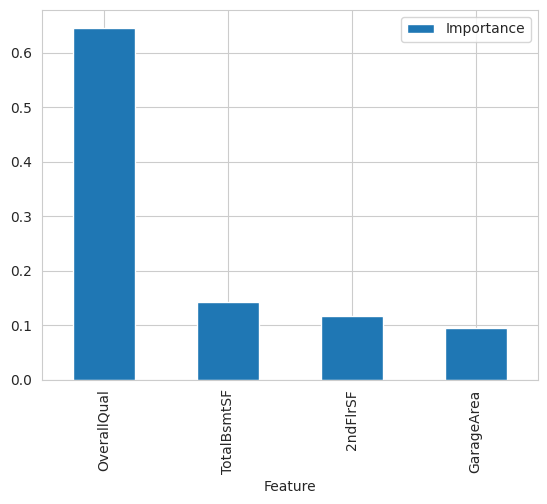

In [109]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 3
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

# Evaluate Regressor Pipeline on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.902
Mean Absolute Error: 17900.24
Mean Squared Error: 604472224.893
Root Mean Squared Error: 24586.017


* Test Set
R2 Score: 0.755
Mean Absolute Error: 23779.14
Mean Squared Error: 1693737981.013
Root Mean Squared Error: 41155.048




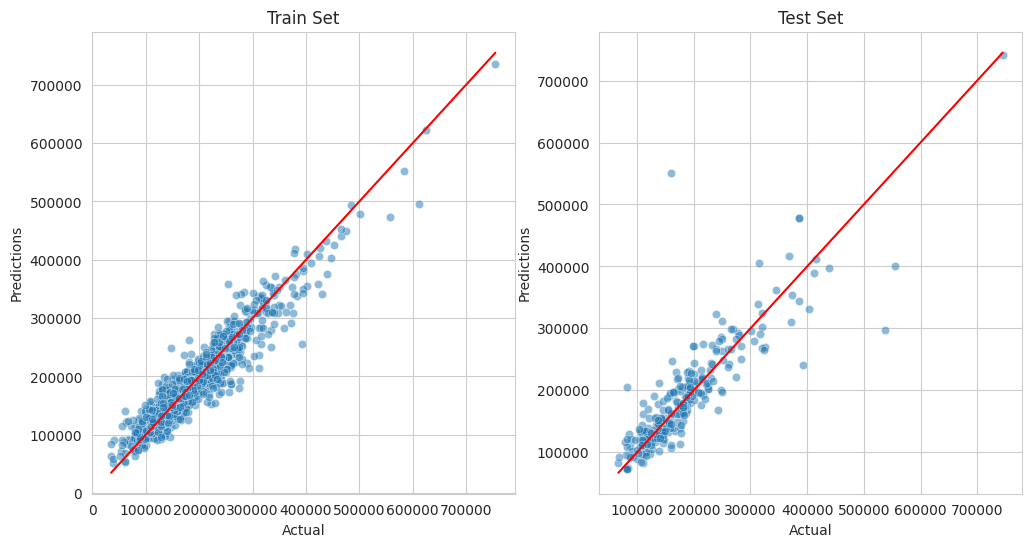

In [110]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Push files to Repo

In [113]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_saleprice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_saleprice/v1'


## Save Train Set

In [114]:
X_train.head()

,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
618,9,1822,0.0,774
870,5,894,0.0,308
92,5,876,0.0,432
817,8,1568,0.0,857
302,7,1541,0.0,843


In [115]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [116]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [117]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Save Test Set

In [119]:
X_test.head()

,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
529,6,2035,0.0,484
491,6,806,620.0,240
459,5,709,224.0,352
279,7,1160,866.0,505
655,6,525,NaN,264


In [120]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [121]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [122]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Save Modelling pipeline for predicting Sales Price

In [123]:
best_regressor_pipeline

Pipeline(steps=[('numerical_imputation',
                 MeanMedianImputer(variables=['OverallQual', 'TotalBsmtSF',
                                              '2ndFlrSF', 'GarageArea'])),
                ('winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalBsmtSF', '2ndFlrSF',
                                       'GarageArea'])),
                ('yjt',
                 YeoJohnsonTransformer(variables=['OverallQual', 'TotalBsmtSF',
                                                  '2ndFlrSF', 'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=0))])

In [124]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_features_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_saleprice/v1/best_features_regressor_pipeline.pkl']

## Save feature importance plot

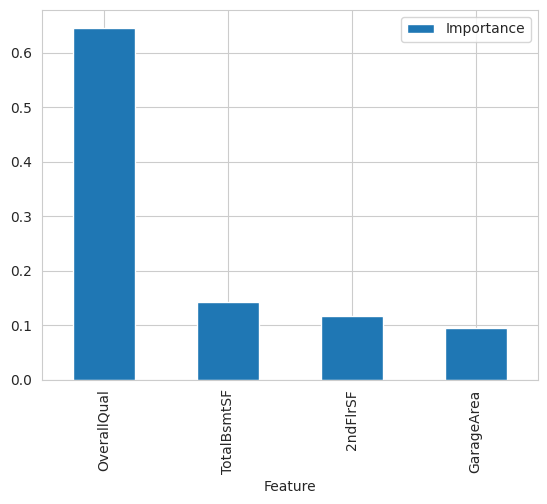

<Figure size 640x480 with 0 Axes>

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

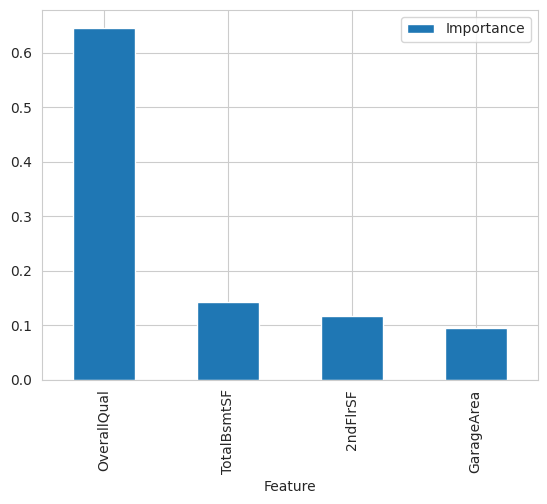

In [128]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')